# scRNA-seq Preprocessing: TABULA MURIS DATA

To prepare the raw data provided by the Tabula Muris Consortium (available on [Figshare](https://figshare.com/projects/Tabula_Muris_Transcriptomic_characterization_of_20_organs_and_tissues_from_Mus_musculus_at_single_cell_resolution/27733)), we implement the steps demonstrated in their [`data_ingest` code](https://github.com/czbiohub/tabula-muris/tree/master/00_data_ingest).  Specifically, they perform some quality filtering on the raw counts, transform and scale the counts, and finally perform some initial dimensionality reduction by reducing the data set to those deemed "most variable" followed by PCA.  In our paper, we wish to demonstrate how the EMBEDR algorithm can be used to evaluate the quality presented by any embedding, so we will try not to deviate from this pipeline, as it still resembles published best practices, although we believe that EMBEDR could be used to evaluate the efficacy of these pipelines themselves!

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import os
import pandas as pd
import re
import scanpy as sc
import seaborn as sns

sns.set(color_codes=True)
matplotlib.rc("font", size=12)
matplotlib.rc("xtick", labelsize=12)
matplotlib.rc("ytick", labelsize=12)
matplotlib.rc("axes", labelsize=16)
matplotlib.rc("axes", titlesize=20)
matplotlib.rc("legend", fontsize=10)
matplotlib.rc("figure", titlesize=16)

%matplotlib inline

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.7 pynndescent==0.5.5


In [2]:
# tissue = "marrow"
# tissue = "brain_non-myeloid"
tissue = "diaphragm"

file_path = "../data/tabula-muris/"
data_name = f"00_facs_raw_data/FACS/{tissue.title()}-counts.csv"
meta_name = f"00_facs_raw_data/metadata_FACS.csv"
anno_name = f"03_tissue_annotation_csv/{tissue.title()}_facs_annotation.csv"

metadata  = pd.read_csv(os.path.join(file_path, meta_name))
annots    = pd.read_csv(os.path.join(file_path, anno_name)).rename(columns={'cell': 'cell_id'})

raw_data  = sc.read_csv(os.path.join(file_path, data_name)).T
raw_data

AnnData object with n_obs × n_vars = 951 × 23433

We then want to merge the metadata and some cell-type annotations into the `anndata` data structure

In [3]:
## Rename the metadata's indices.
raw_data.obs.index.set_names("cell_id", inplace=True)
raw_data.var.index.set_names("gene", inplace=True)

## Create a new column containing just the plate barcode - this is
## what we'll use to merge the experiment metadata.
raw_data.obs['plate.barcode'] = [barcode.split("_")[0].split(".")[1] for barcode in raw_data.obs.index]

## Get the subset of metadata corresponding to the current tissue.
submeta = raw_data.obs.merge(metadata, how='left', on='plate.barcode')
submeta.index = raw_data.obs.index  ## Copy the index
raw_data.obs = submeta.copy()       ## Overwrite the anndata's metadata.

## Merge the Tabula Muris cell-type annotations as well.
raw_data.obs = raw_data.obs.merge(annots, how='left', on='cell_id').set_index('cell_id')

## "." in Python names doesn't work well, so we do some renaming.
col_renames = {col: "_".join(col.split(".")) for col in raw_data.obs.columns}
col_renames.update({"plate.barcode_x": "plate_barcode",
                    "mouse.id_x": "mouse_id",
                    "tissue_x": "tissue",
                    "FACS.selection": "FACS_selection",
                    "mouse.sex_x": "mouse_sex",
                    "subtissue_y": "subtissue"})
raw_data.obs = raw_data.obs.rename(columns=col_renames)

## We also need to do some type coercion
dtypes = {"subsetA": bool,
          "subsetB": bool,
          "subsetC": bool,
          "subsetD": bool,
          "subsetE": bool,}
dtypes = {key: val for key, val in dtypes.items() if key in raw_data.obs.columns}
raw_data.obs = raw_data.obs.astype(dtypes)

## Drop some redundant columns as well!
drop_cols = ["subtissue_x"] + [col for col in raw_data.obs.columns if col[-2:] == '_y']
raw_data.obs = raw_data.obs.drop(columns=drop_cols)

raw_data.obs.head()

,plate_barcode,mouse_id,tissue,FACS_selection,mouse_sex,subtissue,cell_ontology_class,cell_ontology_id,free_annotation,cluster_ids,tSNE_1,tSNE_2
cell_id,,,,,,,,,,,,
A8.D042105.3_11_M.1.1,D042105,3_11_M,Limb_Muscle,Multiple,M,Diaphragm,skeletal muscle satellite stem cell,CL:0008011,NaN,0.0,-8.882184,-10.730514
K10.D042105.3_11_M.1.1,D042105,3_11_M,Limb_Muscle,Multiple,M,Diaphragm,mesenchymal stem cell,CL:0000134,NaN,1.0,5.435094,34.060681
L13.D042105.3_11_M.1.1,D042105,3_11_M,Limb_Muscle,Multiple,M,Diaphragm,mesenchymal stem cell,CL:0000134,NaN,1.0,-0.888768,27.308671
M15.D042105.3_11_M.1.1,D042105,3_11_M,Limb_Muscle,Multiple,M,Diaphragm,endothelial cell,CL:0000115,NaN,3.0,-23.209078,2.695871
N17.D042105.3_11_M.1.1,D042105,3_11_M,Limb_Muscle,Multiple,M,Diaphragm,skeletal muscle satellite stem cell,CL:0008011,NaN,0.0,-20.972265,2.364300


# Quality Filtering

We'll first add some metadata denoting the genes that are spike-ins or ribosomal, then we'll do some normal thresholding to eliminate low-count cells and genes.

In [4]:
## Find any spike-ins and remove them
raw_data.var['is_ERCC'] = [re.search('^ERCC-', gene) is not None for gene in raw_data.var.index]
raw_data.obs['perc_ERCC'] = raw_data.X[:, raw_data.var.is_ERCC].sum(axis=1) / raw_data.X.sum(axis=1)
raw_data = raw_data[:, ~raw_data.var.is_ERCC]

## Count the number of reads in each cell
raw_data.obs['n_reads'] = raw_data.X.sum(axis=1)

## Find any ribosomal genes
raw_data.var['is_ribo'] = [re.search("^Rp[sl][0-9]", gene) is not None for gene in raw_data.var.index]
raw_data.obs['perc_ribo'] = raw_data.X[:, raw_data.var.is_ribo].sum(axis=1) / raw_data.obs.n_reads

## Determine the fraction of Rn45s...
raw_data.var['is_Rn45s'] = [re.search("^Rn45s", gene) is not None for gene in raw_data.var.index]
raw_data.obs['perc_Rn45s'] = raw_data.X[:, raw_data.var.is_Rn45s].sum(axis=1) / raw_data.obs.n_reads

Trying to set attribute `.obs` of view, copying.


Check that there are no ERCCs (spike-ins) in the data!

In [5]:
print(f"There are {len(raw_data.var.index[raw_data.var.is_ERCC])} spike-ins in the data!")

There are 0 spike-ins in the data!


Now we can do some quality control and assess whether we need to filter based on these metadata...

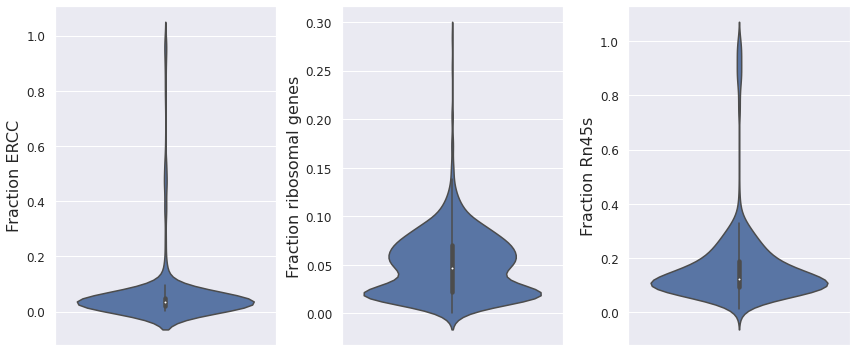

In [6]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 5))

_ = sns.violinplot(data=raw_data.obs.perc_ERCC, ax=ax1)
_ = ax1.set_ylabel("Fraction ERCC")
_ = ax1.set_xticks([])

_ = sns.violinplot(data=raw_data.obs.perc_ribo, ax=ax2)
_ = ax2.set_ylabel("Fraction ribosomal genes")
_ = ax2.set_xticks([])

_ = sns.violinplot(data=raw_data.obs.perc_Rn45s, ax=ax3)
_ = ax3.set_ylabel("Fraction Rn45s")
_ = ax3.set_xticks([])

_ = fig.tight_layout()

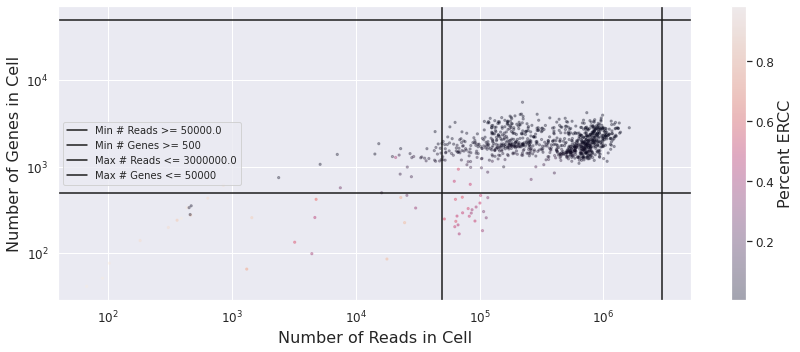

In [7]:
min_genes, max_genes = 500, 50000
min_reads, max_reads = 5e4, 3e6

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

hax = ax.scatter(raw_data.obs.n_reads, (raw_data.X > 0).sum(axis=1), c=raw_data.obs.perc_ERCC, s=5, alpha=0.3)

_ = ax.axvline(min_reads, color='k', label=f"Min # Reads >= {min_reads}")
_ = ax.axhline(min_genes, color='k', label=f"Min # Genes >= {min_genes}")
_ = ax.axvline(max_reads, color='k', label=f"Max # Reads <= {max_reads}")
_ = ax.axhline(max_genes, color='k', label=f"Max # Genes <= {max_genes}")

cax = plt.colorbar(hax, ax=ax)
_ = cax.set_label("Percent ERCC")

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

_ = ax.legend()

_ = ax.set_xlabel("Number of Reads in Cell")
_ = ax.set_ylabel("Number of Genes in Cell")

_ = fig.tight_layout()

We want to note that there is a discrepancy between the filters that are given in the [FACS notebook](https://github.com/czbiohub/tabula-muris/blob/master/00_data_ingest/FACS_Notebook.Rmd) and the [All FACS notebook](https://github.com/czbiohub/tabula-muris/blob/master/00_data_ingest/All_FACS_Notebook.Rmd) and the [boilerplate.r](https://github.com/czbiohub/tabula-muris/blob/master/00_data_ingest/02_tissue_analysis_rmd/boilerplate.R) code in that the latter two do not put an upper bound on reads or genes per cell.  Using the normalization below, we recover the same number of cells and genes.

In [8]:
sc.pp.filter_cells(raw_data, min_genes=min_genes)
sc.pp.filter_cells(raw_data, min_counts=min_reads)
sc.pp.filter_genes(raw_data, min_cells=5)
# sc.pp.filter_cells(raw_data, max_counts=max_reads)

raw_data

filtered out 46 cells that have less than 500 genes expressed
filtered out 35 cells that have less than 50000.0 counts
filtered out 9241 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 870 × 14100
    obs: 'plate_barcode', 'mouse_id', 'tissue', 'FACS_selection', 'mouse_sex', 'subtissue', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'cluster_ids', 'tSNE_1', 'tSNE_2', 'perc_ERCC', 'n_reads', 'perc_ribo', 'perc_Rn45s', 'n_genes', 'n_counts'
    var: 'is_ERCC', 'is_ribo', 'is_Rn45s', 'n_cells'

We can see that the filtering results in 5037 cells, each containing a measurement for 17,369 genes.

Looking at the quality plots again, we see that the cells that were mostly spike-ins have been removed.  However, there are still some cells left that have high ERCC or ribosomal gene content, so we will also place a filter on those.  This results in the removal of another 267 cells and 71 genes.

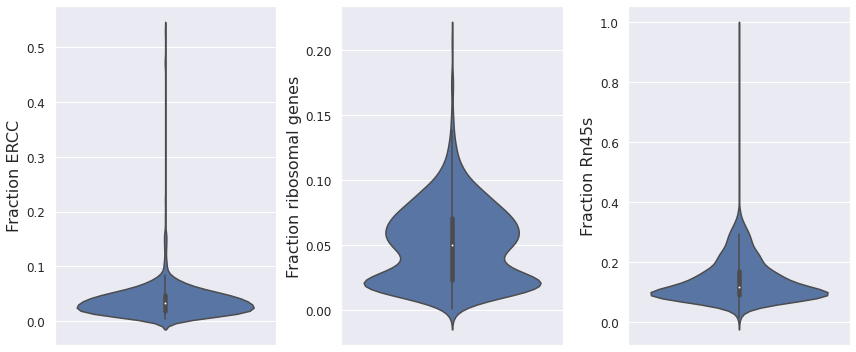

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 5))

_ = sns.violinplot(data=raw_data.obs.perc_ERCC, ax=ax1)
_ = ax1.set_ylabel("Fraction ERCC")
_ = ax1.set_xticks([])

_ = sns.violinplot(data=raw_data.obs.perc_ribo, ax=ax2)
_ = ax2.set_ylabel("Fraction ribosomal genes")
_ = ax2.set_xticks([])

_ = sns.violinplot(data=raw_data.obs.perc_Rn45s, ax=ax3)
_ = ax3.set_ylabel("Fraction Rn45s")
_ = ax3.set_xticks([])

_ = fig.tight_layout()

In [10]:
max_perc_ERCC  = 0.1
max_perc_ribo  = 0.1
max_perc_Rn45s = 0.4

raw_data = raw_data[raw_data.obs.perc_ERCC < max_perc_ERCC]
raw_data = raw_data[raw_data.obs.perc_ribo < max_perc_ribo]
raw_data = raw_data[raw_data.obs.perc_Rn45s < max_perc_Rn45s]

sc.pp.filter_cells(raw_data, min_genes=min_genes)
sc.pp.filter_cells(raw_data, min_counts=min_reads)
sc.pp.filter_genes(raw_data, min_cells=5)

raw_data

Trying to set attribute `.obs` of view, copying.


filtered out 130 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 811 × 13970
    obs: 'plate_barcode', 'mouse_id', 'tissue', 'FACS_selection', 'mouse_sex', 'subtissue', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'cluster_ids', 'tSNE_1', 'tSNE_2', 'perc_ERCC', 'n_reads', 'perc_ribo', 'perc_Rn45s', 'n_genes', 'n_counts'
    var: 'is_ERCC', 'is_ribo', 'is_Rn45s', 'n_cells'

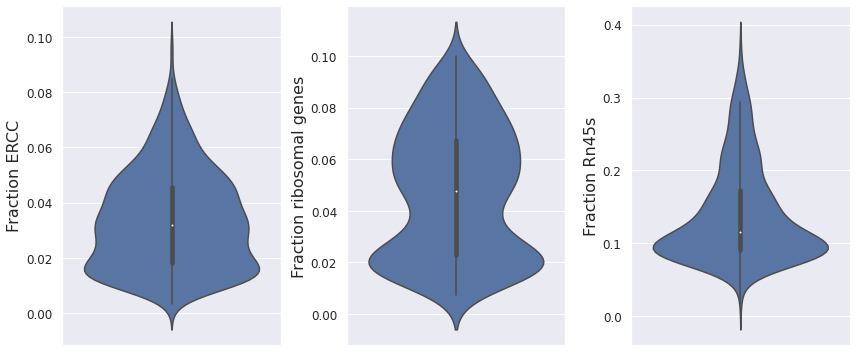

In [11]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 5))

_ = sns.violinplot(data=raw_data.obs.perc_ERCC, ax=ax1)
_ = ax1.set_ylabel("Fraction ERCC")
_ = ax1.set_xticks([])

_ = sns.violinplot(data=raw_data.obs.perc_ribo, ax=ax2)
_ = ax2.set_ylabel("Fraction ribosomal genes")
_ = ax2.set_xticks([])

_ = sns.violinplot(data=raw_data.obs.perc_Rn45s, ax=ax3)
_ = ax3.set_ylabel("Fraction Rn45s")
_ = ax3.set_xticks([])

_ = fig.tight_layout()

# Normalize, Scale, and Find Variable Genes

To finish the preprocessing, the filtered counts are normalized, logged, and then scaled.  We then use scanpy's implementation of the `Find_Variable_Genes` function to identify highly variable genes.  This function identified 5,016 highly variable genes.  These genes are then used to generate a projection of the data using PCA.

In [12]:
data = raw_data.copy()
sc.pp.normalize_total(data, target_sum=1e6)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, max_mean=np.inf, n_bins=50)
sc.pp.scale(data)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


There are 3749 highly variable genes


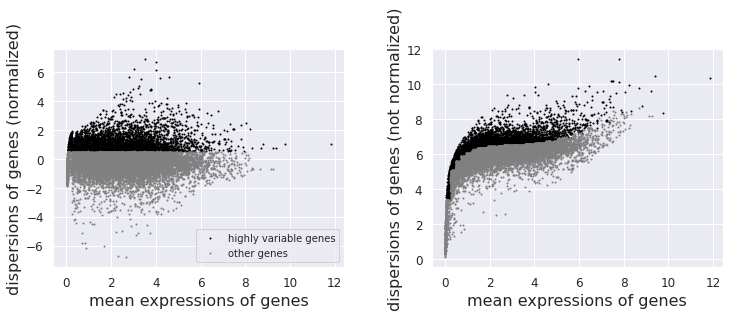

<Figure size 432x288 with 0 Axes>

In [13]:
print(f"There are {sum(data.var.highly_variable)} highly variable genes")
sc.pl.highly_variable_genes(data)
_ = plt.gcf().tight_layout()

In the [vignette for the Marrow data](https://github.com/czbiohub/tabula-muris/blob/master/00_data_ingest/02_tissue_analysis_rmd/Marrow_facs.Rmd) `n_comps=18` principal components were used.  This seemed too small when we looked at a larger scree plot, so we will use 50.

In [14]:
sc.tl.pca(data, n_comps=200)

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:00)


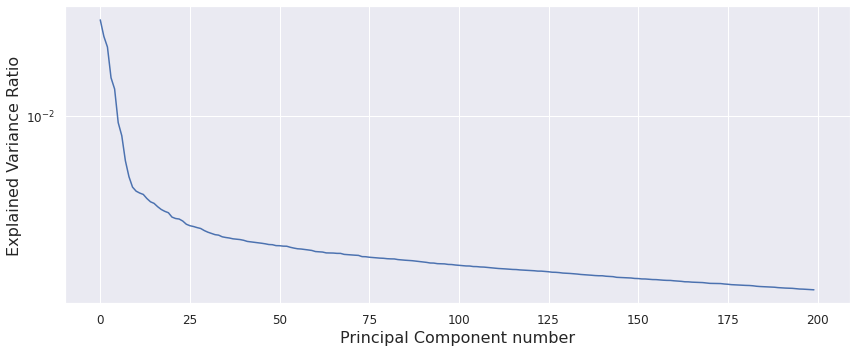

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
_ = ax.plot(data.uns['pca']['variance_ratio'])
_ = ax.set_yscale('log')

_ = ax.set_xlabel("Principal Component number")
_ = ax.set_ylabel("Explained Variance Ratio")

_ = fig.tight_layout()

In [16]:
sc.tl.pca(data, n_comps=50)
data.obsm['X_pca'].shape

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


(811, 50)

In [17]:
sc.tl.tsne(data)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)


In [18]:
sc.pp.neighbors(data)
sc.tl.umap(data)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


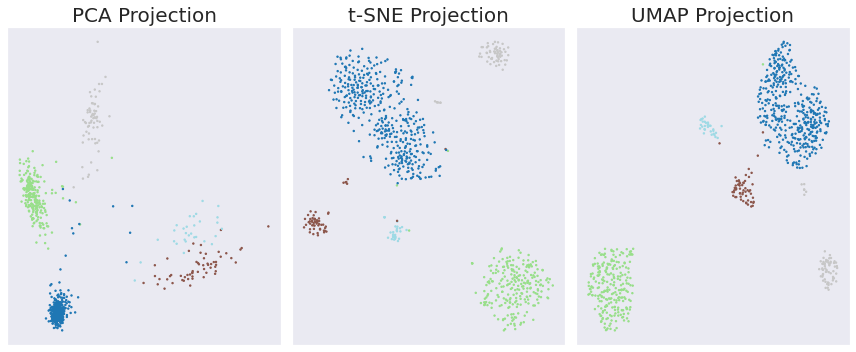

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 5))

_ = ax1.scatter(*data.obsm['X_pca'][:, :2].T, s=2, c=data.obs.cluster_ids.values, cmap='tab20')

_ = ax1.set_title("PCA Projection")
_ = ax1.set_xticks([])
_ = ax1.set_yticks([])

_ = ax2.scatter(*data.obsm['X_tsne'].T, s=2, c=data.obs.cluster_ids.values, cmap='tab20')

_ = ax2.set_title("t-SNE Projection")
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])

_ = ax3.scatter(*data.obsm['X_umap'].T, s=2, c=data.obs.cluster_ids.values, cmap='tab20')

_ = ax3.set_title("UMAP Projection")
_ = ax3.set_xticks([])
_ = ax3.set_yticks([])

_ = fig.tight_layout()

We can then save this object to file to use in the EMBEDR analysis.

In [20]:
data.write(os.path.join(file_path, f"04_facs_processed_data/FACS/Processed_{tissue.title()}.h5ad"))
data.write_csvs(os.path.join(file_path, f"04_facs_processed_data/FACS/Processed_{tissue.title()}.csv"))

/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'plate_barcode' as categorical
/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mouse_id' as categorical
/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be 